<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB6.1_Temporary_market_impact_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating the temporary market impact function

---

This is a short notebook showing how the temporary market impact function can be estimated using real limit order book data.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the data file

Our data file is a csv file which contains the some limit order book data of Microsoft stock on 21 June 2012. It contains 30 levels of pricing data where each level consists of ask price, ask size, bid price and bid size. The columns of this file are arranged in the order of:

a1, aq1, b1, bq1, a2, aq2, b2, bq2, ......, a30, aq30, b30, bq30

Here ai, aqi, bi, bqi refer to the ask price, ask size, bid price and bid size of level i respectively.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/My Drive/Data/crypto/lob/'
#filepath = os.path.join(PATH, 'btc_lob_20191112_20191120_10s.csv')

####################################################################
# If you have a csv file locally on your computer, then it is not very convenient to use Colab
# because you cannot easily access your local file from Colab.
# If you really want to use Colab, one solution is to save the csv file on your Google Drive
# and then mount your drive using the package "from google.colab import drive"

# If you run the notebook on Jupyer, then replace the filepath variable below as somethinig like
# filepath = 'C:\Users\yourname\Documents\btc_lob_20191112_20191120_10s.csv'
####################################################################

filepath = 'https://www.dropbox.com/s/4ewhk5nhh18v0om/MSFT_2012-06-21_34200000_37800000_orderbook_30.csv?dl=1'

# Open and save the file content to a dataframe variable called "data"
data = pd.read_csv(filepath, header=None)

# Take a look at the loaded data
display(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,309900,3788,309500,300,310500,100,309300,3986,310600,100,309200,100,310700,200,309100,300,310800,200,308900,100,310900,9348,308800,200,311000,1800,308700,200,311100,4500,308600,400,311300,100,308500,400,311400,100,308400,1600,...,326800,100,293500,100,329200,100,292500,100,332900,300,291400,400,337900,1000,290500,20,339000,20,289400,100,344800,10,287000,2000,346600,40,284900,100,363600,100,274500,20,366300,100,271700,20,367800,100,271500,10000
1,309900,3788,309500,300,310500,200,309300,3986,310600,100,309200,100,310700,200,309100,300,310800,200,308900,100,310900,9348,308800,200,311000,1800,308700,200,311100,4500,308600,400,311300,100,308500,400,311400,100,308400,1600,...,326800,100,293500,100,329200,100,292500,100,332900,300,291400,400,337900,1000,290500,20,339000,20,289400,100,344800,10,287000,2000,346600,40,284900,100,363600,100,274500,20,366300,100,271700,20,367800,100,271500,10000
2,309900,3788,309500,300,310400,100,309300,3986,310500,200,309200,100,310600,100,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,309200,100,310600,100,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,309200,100,310600,200,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140302,308500,15930,308400,8789,308600,12473,308300,15196,308700,14603,308200,12626,308800,13278,308100,18348,308900,18826,308000,11211,309000,12320,307900,14040,309100,14595,307800,7000,309200,11066,307700,11700,309300,11600,307600,1900,309400,10900,307500,8400,...,310500,56761,306400,2800,310600,600,306300,650,310700,1100,306200,6750,310800,900,306100,2000,310900,3300,306000,23100,311000,950,305900,200,311100,600,305800,100,311200,1000,305700,2800,311300,4100,305600,1400,311400,1634,305500,1099
140303,308500,15930,308400,8459,308600,12473,308300,15196,308700,14603,308200,12626,308800,13278,308100,18348,308900,18826,308000,11211,309000,12320,307900,14040,309100,14595,307800,7000,309200,11066,307700,11700,309300,11600,307600,1900,309400,10900,307500,8400,...,310500,56761,306400,2800,310600,600,306300,650,310700,1100,306200,6750,310800,900,306100,2000,310900,3300,306000,23100,311000,950,305900,200,311100,600,305800,100,311200,1000,305700,2800,311300,4100,305600,1400,311400,1634,305500,1099
140304,308500,15930,308400,8459,308600,12473,308300,15196,308700,14523,308200,12626,308800,13278,308100,18348,308900,18826,308000,11211,309000,12320,307900,14040,3

The file does not have the column header to begin with. So for convenience we can assign the columns names to the dataframe manually.

In [ ]:
list_features = []
all_a = []
all_aq = []

depth = 30 # the depth of the LOB in the data

for i in range(depth):

    list_features.append("a" + str(i+1))
    list_features.append("aq" + str(i+1))
    list_features.append("b" + str(i+1))
    list_features.append("bq" + str(i+1))

    all_a.append("a" + str(i+1))
    all_aq.append("aq" + str(i+1))

data.columns = list_features
display(data)

,a1,aq1,b1,bq1,a2,aq2,b2,bq2,a3,aq3,b3,bq3,a4,aq4,b4,bq4,a5,aq5,b5,bq5,a6,aq6,b6,bq6,a7,aq7,b7,bq7,a8,aq8,b8,bq8,a9,aq9,b9,bq9,a10,aq10,b10,bq10,...,a21,aq21,b21,bq21,a22,aq22,b22,bq22,a23,aq23,b23,bq23,a24,aq24,b24,bq24,a25,aq25,b25,bq25,a26,aq26,b26,bq26,a27,aq27,b27,bq27,a28,aq28,b28,bq28,a29,aq29,b29,bq29,a30,aq30,b30,bq30
0,309900,3788,309500,300,310500,100,309300,3986,310600,100,309200,100,310700,200,309100,300,310800,200,308900,100,310900,9348,308800,200,311000,1800,308700,200,311100,4500,308600,400,311300,100,308500,400,311400,100,308400,1600,...,326800,100,293500,100,329200,100,292500,100,332900,300,291400,400,337900,1000,290500,20,339000,20,289400,100,344800,10,287000,2000,346600,40,284900,100,363600,100,274500,20,366300,100,271700,20,367800,100,271500,10000
1,309900,3788,309500,300,310500,200,309300,3986,310600,100,309200,100,310700,200,309100,300,310800,200,308900,100,310900,9348,308800,200,311000,1800,308700,200,311100,4500,308600,400,311300,100,308500,400,311400,100,308400,1600,...,326800,100,293500,100,329200,100,292500,100,332900,300,291400,400,337900,1000,290500,20,339000,20,289400,100,344800,10,287000,2000,346600,40,284900,100,363600,100,274500,20,366300,100,271700,20,367800,100,271500,10000
2,309900,3788,309500,300,310400,100,309300,3986,310500,200,309200,100,310600,100,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,309200,100,310600,100,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,309200,100,310600,200,309100,300,310700,200,308900,100,310800,200,308800,200,310900,9348,308700,200,311000,1800,308600,400,311100,4500,308500,400,311300,100,308400,1600,...,325000,100,293500,100,326800,100,292500,100,329200,100,291400,400,332900,300,290500,20,337900,1000,289400,100,339000,20,287000,2000,344800,10,284900,100,346600,40,274500,20,363600,100,271700,20,366300,100,271500,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140302,308500,15930,308400,8789,308600,12473,308300,15196,308700,14603,308200,12626,308800,13278,308100,18348,308900,18826,308000,11211,309000,12320,307900,14040,309100,14595,307800,7000,309200,11066,307700,11700,309300,11600,307600,1900,309400,10900,307500,8400,...,310500,56761,306400,2800,310600,600,306300,650,310700,1100,306200,6750,310800,900,306100,2000,310900,3300,306000,23100,311000,950,305900,200,311100,600,305800,100,311200,1000,305700,2800,311300,4100,305600,1400,311400,1634,305500,1099
140303,308500,15930,308400,8459,308600,12473,308300,15196,308700,14603,308200,12626,308800,13278,308100,18348,308900,18826,308000,11211,309000,12320,307900,14040,309100,14595,307800,7000,309200,11066,307700,11700,309300,11600,307600,1900,309400,10900,307500,8400,...,310500,56761,306400,2800,310600,600,306300,650,310700,1100,306200,6750,310800,900,306100,2000,310900,3300,306000,23100,311000,950,305900,200,311100,600,305800,100,311200,1000,305700,2800,311300,4100,305600,1400,311400,1634,305500,1099
140304,308500,15930,308400,8459,308600,12473,308300,15196,308700,14523,308200,12626,30880

As an example, let's compute the temporary market impact using the snapshot of the LOB at time point 0.

No handles with labels found to put in legend.


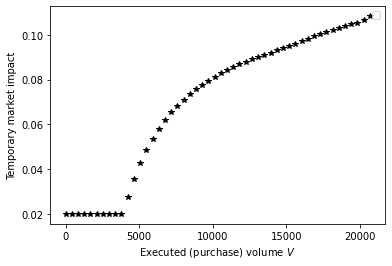

In [ ]:
time_pt = 0

mid_px = (data['a1'].iloc[time_pt] + data['b1'].iloc[time_pt]) / 2

ask_price = (data[all_a].iloc[time_pt]).to_numpy()
ask_vol = (data[all_aq].iloc[time_pt]).to_numpy()

cum_ask_vol = np.cumsum(ask_vol)
v_sold = np.linspace(1, np.max(cum_ask_vol)*0.8)
exec_px = np.zeros_like(v_sold)

for j, v in enumerate(v_sold):

    sold_notional = 0

    for i in range(depth):
        if v > cum_ask_vol[i]:
            sold_notional = sold_notional + ask_price[i] * ask_vol[i]
        else:
            if i != 0:
                sold_notional = sold_notional + ask_price[i] * (v - cum_ask_vol[i-1])
            else:
                sold_notional = sold_notional + ask_price[i] * v
            break

    exec_px[j] = (sold_notional / v) / 10000

linear_fit = np.polyfit(v_sold, exec_px - mid_px / 10000, 1)

plt.plot(v_sold, exec_px - mid_px / 10000, 'k*')
plt.xlabel('Executed (purchase) volume $V$')
plt.ylabel('Temporary market impact')
plt.legend()

We can also perform the regression using the estimated temporary market impact functions across multiple time points. For illustration, let's consider the LOB data from the first fifty time points. We can fit a linear regression to all the data points of market impact where the slope can reflect the degree of temporary market impact.

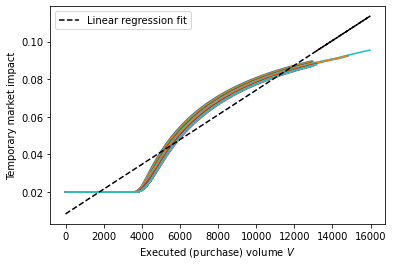

In [ ]:
all_v_sold = []
all_impact = []

for time_pt in range(50):

    mid_px = (data['a1'].iloc[time_pt] + data['b1'].iloc[time_pt]) / 2

    ask_price = (data[all_a].iloc[time_pt]).to_numpy()
    ask_vol = (data[all_aq].iloc[time_pt]).to_numpy()

    cum_ask_vol = np.cumsum(ask_vol)
    v_sold = np.linspace(1, np.max(cum_ask_vol)*0.5)
    exec_px = np.zeros_like(v_sold)

    for j, v in enumerate(v_sold):

        sold_notional = 0

        for i in range(depth):
            if v > cum_ask_vol[i]:
                sold_notional = sold_notional + ask_price[i] * ask_vol[i]
            else:
                if i != 0:
                    sold_notional = sold_notional + ask_price[i] * (v - cum_ask_vol[i-1])
                else:
                    sold_notional = sold_notional + ask_price[i] * v
                break

        exec_px[j] = (sold_notional / v) / 10000

    plt.plot(v_sold, exec_px - mid_px / 10000)
    plt.xlabel('Executed (purchase) volume $V$')
    plt.ylabel('Temporary market impact')


    all_v_sold = np.concatenate((all_v_sold, v_sold))
    all_impact = np.concatenate((all_impact, exec_px - mid_px / 10000))

linear_fit = np.polyfit(all_v_sold, all_impact, 1)
plt.plot(all_v_sold, linear_fit[1] + linear_fit[0] * all_v_sold, 'k--', label="Linear regression fit")
plt.legend()